In [70]:
import re

import networkx as nx

from IPython.display import Image, display
from collections import defaultdict, Counter
from itertools import combinations

In [46]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('seaborn-muted')

In [47]:
class Token:
    
    def __init__(self, token, ignore_case=True, scrub_re='\.'):
        
        self.ignore_case = ignore_case
        self.scrub_re = scrub_re
        
        self.token = token
        self.token_clean = self._clean(token)
        
    def _clean(self, token):
        
        if self.ignore_case:
            token = token.lower()
            
        if self.scrub_re:
            token = re.sub(self.scrub_re, '', token)
            
        return token
    
    def __call__(self, input_token):
        return self._clean(input_token) == self.token_clean
    
    def __repr__(self):
        return '%s<%s>' % (self.__class__.__name__, self.token_clean)
    
    def __str__(self):
        return '<%s>' % self.token_clean
    
    def __hash__(self):
        return hash((id(self.__class__), self.token_clean, self.ignore_case, self.scrub_re))
    
    def __eq__(self, other):
        return hash(self) == hash(other)

In [50]:
class GeoFSA(nx.DiGraph):
    
    def __init__(self):
        super().__init__()
        self.start_node = self.next_node()
        
    def next_node(self):
        """Get next integer node id, counting up.
        """
        node = max(self.nodes) + 1 if self.nodes else 0
        self.add_node(node)
        return node
        
    def add_token(self, accept_fn, parent=None, optional=False):
        
        s1 = parent if parent else self.start_node
        
        s2 = None
        for d, attrs in self[s1].items():
            if attrs.get('accept_fn') == accept_fn:
                s2 = d
                break
                
        if not s2:
            s2 = self.next_node()
        
        self.add_edge(s1, s2, accept_fn=accept_fn, label=str(accept_fn))
        
        last_node = s2
        
        # Add skip transition if optional.
        if optional:
            s3 = self.next_node()
            self.add_edge(s2, s3, label='ε')
            self.add_edge(s1, s3, label='ε')
            last_node = s3
        
        return last_node

In [51]:
def plot(g):
    dot = nx.drawing.nx_pydot.to_pydot(g)
    dot.set_rankdir('LR')
    display(Image(dot.create_png()))

In [157]:
g = GeoFSA()

south = g.add_token(Token('South'))
lake = g.add_token(Token('Lake'), south)
tahoe = g.add_token(Token('Tahoe'), lake)
comma = g.add_token(Token(','), tahoe, optional=True)
ca = g.add_token(Token('CA'), comma)
california = g.add_token(Token('California'), comma)

los = g.add_token(Token('Los'))
angeles = g.add_token(Token('Angeles'), los)
comma = g.add_token(Token(','), angeles, optional=True)
ca = g.add_token(Token('CA'), comma)
california = g.add_token(Token('California'), comma)

south = g.add_token(Token('South'))
bend = g.add_token(Token('Bend'), south)
comma = g.add_token(Token(','), bend, optional=True)
il = g.add_token(Token('IL'), comma)
illinois = g.add_token(Token('Illinois'), comma)

# g2 = GeoFSA()
los = g.add_token(Token('Los'))
angeles = g.add_token(Token('Gatos'), los)
comma = g.add_token(Token(','), angeles, optional=True)
ca = g.add_token(Token('CA'), comma)
california = g.add_token(Token('California'), comma)

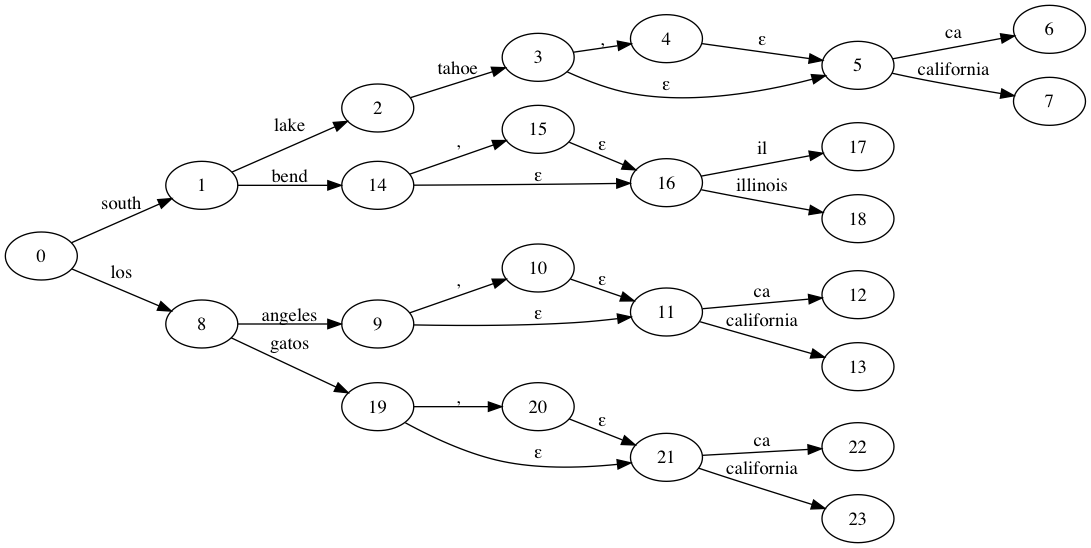

In [158]:
plot(g)

In [159]:
leaves = [n for n in g.nodes() if g.out_degree(n)==0]

In [160]:
leaves

[6, 7, 12, 13, 17, 18, 22, 23]

In [161]:
removed = set()
for n1, n2 in combinations(leaves, 2):
    
    if n1 in removed or n2 in removed:
        continue
    
    n1_in = set([v[2].get('accept_fn') for v in g.in_edges(n1, data=True)])
    n2_in = set([v[2].get('accept_fn') for v in g.in_edges(n2, data=True)])
    
    if n1_in == n2_in:
        g = nx.contracted_nodes(g, n1, n2)
        removed.add(n2)

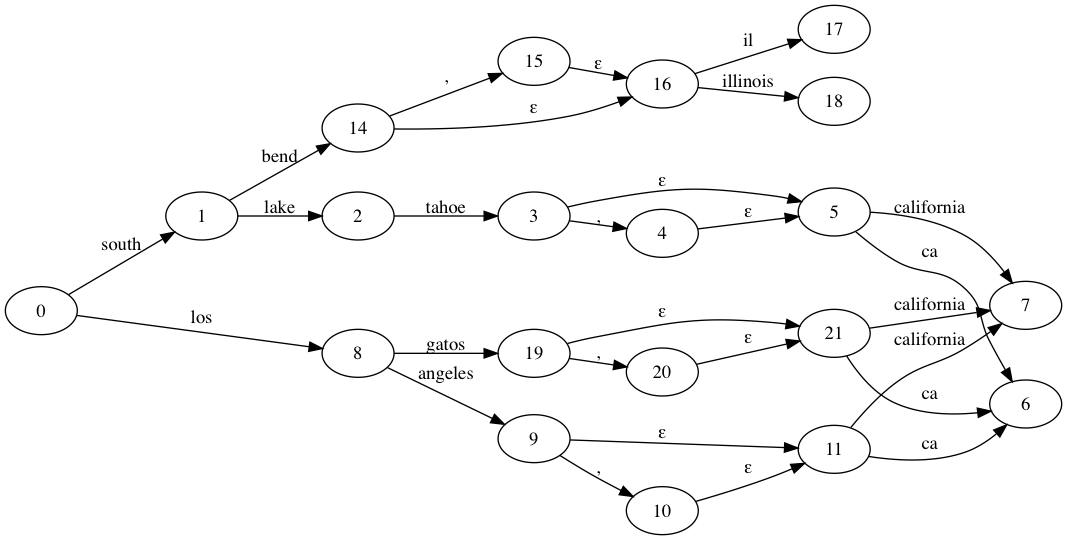

In [162]:
plot(g)

In [166]:
def merge_key(n):
    
    out_edges = frozenset([v[2].get('accept_fn') for v in g.out_edges(n, data=True)])
    desc = frozenset(nx.descendants(g, n))
    
    return (out_edges, desc)

In [167]:
merge_key(21)

(frozenset({Token<ca>, Token<california>}), frozenset({6, 7}))

In [175]:
inner_keys = defaultdict(list)

inner = [n for n in g.nodes() if g.out_degree(n) > 0]

for n in inner:
    inner_keys[merge_key(n)].append(n)
    
for nodes in inner_keys.values():
    if len(nodes) > 1:
        for n in nodes[1:]:
            g = nx.contracted_nodes(g, nodes[0], n)

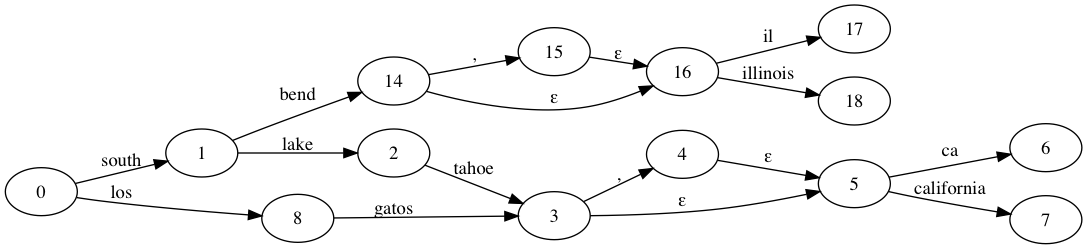

In [176]:
plot(g)